In [ ]:
#!pip install datasets
#!pip install scipy==1.12

In [ ]:
#Check Python version.
import sys
assert sys.version_info[0] == 3
assert sys.version_info[1] >= 8

from platform import python_version
assert int(python_version().split(".")[1]) >= 5, "Please upgrade your Python version following the instructions in \
    the README.md file found in the same directory as this notebook. Your Python version is " + python_version()

#Word Embeddings using Genism.
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
#Print and plot.
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

#Load dataset.
from datasets import load_dataset
imdbData = load_dataset("stanfordnlp/imdb")

import re
import numpy as np
import random
import scipy as sp
#Dimensionality Reduction.
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

startToken = '<START>'
endToken = '<END>'
numSamples = 150

np.random.seed(0)
random.seed(0)

### Part 1: Count-Based Word Vectors

#### Plotting Co-Occurrence Word Embeddings

In [ ]:
def readCorpus():
    '''Read files from the Large Movie Review Dataset.
        Params: category (string): category name.
        Return: list of lists. Each inner list are processed tokens from each file.'''

    #Retrieve the first 150 samples from training data.
    files = imdbData["train"]["text"][:numSamples]
    return [[startToken] + [re.sub(r'[^\w]', '', w.lower()) for w in f.split(" ")] + [endToken] for f in files]

In [ ]:
imdbCorpus = readCorpus()
pprint.pprint(imdbCorpus[:3], compact=True, width=100)
print("corpus size: ", len(imdbCorpus[0]))

[['<START>', 'i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because',
  'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first',
  'released', 'in', '1967', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized',
  'by', 'us', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', 'therefore',
  'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to',
  'see', 'this', 'for', 'myselfbr', 'br', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young',
  'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything',
  'she', 'can', 'about', 'life', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her',
  'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average',
  'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam',
  'war', 'and', 'race', 'issu

#### Question 1.1: Implement distinct_words

In [ ]:
def distinctWords(corpus):
    '''Determine a list of distinct words for the corpus.
       Params: corpus (list of list of strings): corpus of documents.
       Return: corpus_words (list of strings): sorted list of distinct words across the corpus.
               n_corpus_words (integer): number of distinct words across the corpus.'''

    #Unwrap entire corpus into a list of words.
    wordList = [word for reviews in corpus for word in reviews]
    #Convert to set for unique words, then sort alphabetically.
    uniqueWord_list = sorted(set(wordList))
    #Get count.
    num_uniqueWord = len(uniqueWord_list)
    return uniqueWord_list, num_uniqueWord

In [ ]:
# ---------------------
# Run this sanity check.
# Note that this not an exhaustive check for correctness.
# ---------------------

#Define toy corpus.
testCorpus = ["{} All that glitters isn't gold {}".format(startToken, endToken).split(" "),
              "{} All's well that ends well {}".format(startToken, endToken).split(" ")]
uniqueWord_testCorpus, num_uniqueWord_testCorpus = distinctWords(testCorpus)

#Correct answers.
acc_uniqueWord_testCorpus = sorted([startToken, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", endToken])
acc_num_uniqueWord_testCorpus = len(acc_uniqueWord_testCorpus)

#Test correct number of words.
assert(num_uniqueWord_testCorpus == acc_num_uniqueWord_testCorpus), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(acc_num_uniqueWord_testCorpus, num_uniqueWord_testCorpus)

#Test correct words.
assert(uniqueWord_testCorpus == acc_uniqueWord_testCorpus), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(acc_uniqueWord_testCorpus), str(uniqueWord_testCorpus))

#Print Success.
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


#### Question 1.2: Implement compute_co_occurrence_matrix

In [ ]:
def gen_co_occurrenceMatrix(corpus, windowSize=4):
    '''Compute co-occurrence matrix for the given corpus and windowSize (default of 4).
       Note: Each word in a document should be at the center of a window. Words near edges will have a smaller number of co-occurring words.
       Params: corpus (list of list of strings): corpus of documents.
               windowSize (int): size of context window.
       Return:
               M (a symmetric numpy matrix of shape (number of unique words in the corpus, number of unique words in the corpus)):
               Co-occurence matrix of word counts.
               The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinctWords function.
               word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.'''

    uniqueWord_list, num_uniqueWord = distinctWords(corpus)
    #Initiate square matrix | Size = Number of unique words.
    M = np.zeros((num_uniqueWord, num_uniqueWord))
    #Enumerate will auto generate index. Words are SORTED alphabetically here.
    word2indexDict = {word: index for index, word in enumerate(uniqueWord_list)}

    #Iterate through each review.
    for review in corpus:
        reviewLength = len(review)
        #Index list based on global unique word2indexDict.
        reviewIndices = [word2indexDict[word] for word in review]

        #Iterate through each word, enumerate will yield (index, global unique index)
        for index, wordIndex in enumerate(reviewIndices):
            #Previous 4 words. If less than 4 words, start at the beginning.
            windowStart = max(0, index - windowSize)
            #Next 4 words. If less than 4 words, up till end of the review.
            windowEnd = min(reviewLength, index + 1 + windowSize)

            #Iterate through each word -- by index -- within window size.
            for m in range(windowStart, windowEnd):
                #Exclude self-occurence.
                if index != m:
                    #Adding count -- (current word, nearby word).
                    M[wordIndex, reviewIndices[m]] +=1

    return M, word2indexDict

In [ ]:
# ---------------------
# Run this sanity check.
# Note that this is not an exhaustive check for correctness.
# ---------------------

#Define toy corpus and get co-occurrence matrix
testCorpus = ["{} All that glitters isn't gold {}".format(startToken, endToken).split(" "), "{} All's well that ends well {}".format(startToken, endToken).split(" ")]
testMatrix, test_word2indexDict = gen_co_occurrenceMatrix(testCorpus, windowSize=1)

#Correct matrix M and word2indexDict.
acc_testMatrix = np.array(
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]])
acc_uniqueWord_testCorpus = sorted([startToken, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", endToken])
acc_test_word2indexDict = dict(zip(acc_uniqueWord_testCorpus, range(len(acc_uniqueWord_testCorpus))))

#Test correct word2indexDict.
assert(acc_test_word2indexDict == test_word2indexDict), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(acc_test_word2indexDict, test_word2indexDict)

#Test correct matrix M shape.
assert(testMatrix.shape == acc_testMatrix.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(textMatrix.shape, acc_testMatrix.shape)

#Test correct matrix M values.
for w1 in acc_test_word2indexDict.keys():
    idx1 = acc_test_word2indexDict[w1]
    for w2 in acc_test_word2indexDict.keys():
        idx2 = acc_test_word2indexDict[w2]
        student = testMatrix[idx1, idx2]
        correct = acc_testMatrix[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(acc_testMatrix)
            print("Your M: ")
            print(testMatrix)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

#Print Success.
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


#### Question 1.3: Implement reduce_to_k_dim

In [ ]:
def k_dim_matrixReduce(M, k=2):
    '''Reduce a co-occurence count matrix of dimensionality (num_uniqueWord, num_uniqueWord)
        to a matrix of dimensionality (num_uniqueWord, k) using SVD function from Scikit-Learn.
       Params: M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
               k (int): embedding size of each word after dimension reduction
       Return: reducedM (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
               In terms of the SVD from math class, this actually returns U * S'''

    #For TruncatedSVD
    n_iters = 10
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    #n_components: Desired output dimensionality.
    #n_iters: Number of iterations for randomized SVD solver, default = 5.
    svd = TruncatedSVD(n_components = k, n_iter = n_iters)
    reducedM = svd.fit_transform(M)
    print("Done.")
    return reducedM

In [ ]:
# ---------------------
# Run this sanity check.
# Note that this is not an exhaustive check for correctness.
# In fact we only check that your reducedM has the right dimensions.
# ---------------------

#Define toy corpus and run student code.
testCorpus = ["{} All that glitters isn't gold {}".format(startToken, endToken).split(" "), "{} All's well that ends well {}".format(startToken, endToken).split(" ")]
testMatrix, test_word2indexDict = gen_co_occurrenceMatrix(testCorpus, windowSize=1)
reduced_testMatrix = k_dim_matrixReduce(testMatrix, k=2)

#Test proper dimensions.
assert (reduced_testMatrix.shape[0] == 10), "M_reduced has {} rows; should have {}".format(reduced_testMatrix.shape[0], 10)
assert (reduced_testMatrix.shape[1] == 2), "M_reduced has {} columns; should have {}".format(reduced_testMatrix.shape[1], 2)

#Print Success.
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [ ]:
print("Reduce test Matrix output (k=2):")
reduced_testMatrix

Reduce test Matrix output (k=2):


array([[ 6.54802087e-01, -7.83221122e-01],
       [ 5.20200324e-01,  9.43689571e-16],
       [ 7.05647176e-01,  4.84057274e-01],
       [ 7.05647176e-01, -4.84057274e-01],
       [ 1.02780472e+00, -2.22044605e-16],
       [ 6.54802087e-01,  7.83221122e-01],
       [ 3.82258491e-01,  6.56224003e-01],
       [ 3.82258491e-01, -6.56224003e-01],
       [ 1.39420808e+00, -1.06179274e+00],
       [ 1.39420808e+00,  1.06179274e+00]])

#### Question 1.4: Implement plot_embeddings

In [ ]:
def plotEmbeddings(reducedM, word2indexDict, wordList):
    '''Plot in a scatterplot the embeddings of the words specified in the list "words".
       NOTE: Not plotting all the words in reducedM / word2indexDict. Include a label next to each point.
       Params: M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings.
               word2ind (dict): dictionary that maps word to indices for matrix M.
               words (list of strings): words whose embeddings we want to visualize.'''

    for word in wordList:
        #Get the index, then corresponding embedding.
        wordIndex = word2indexDict[word]
        embedding = reducedM[wordIndex]

        plt.scatter(embedding[0], embedding[1], marker='x', color='red')
        #Include label next to each point.
        plt.text(embedding[0], embedding[1], word, fontsize = 7)

    plt.title("Word Embeddings")
    plt.show()

--------------------------------------------------------------------------------
Outputted Plot:


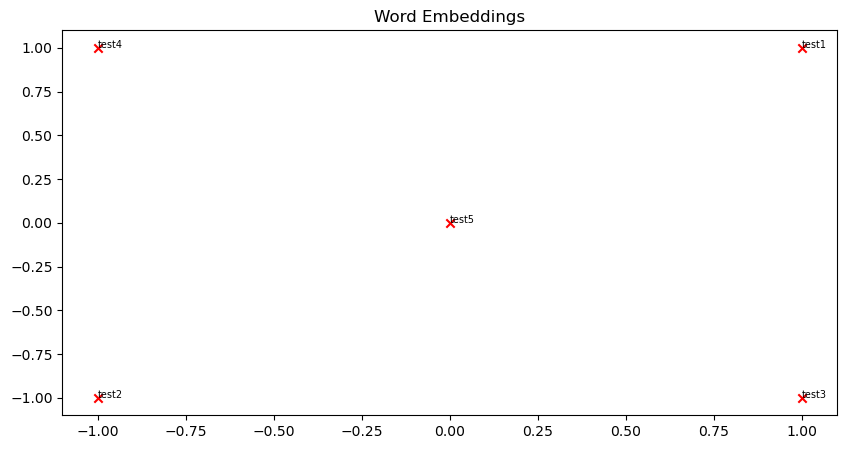

--------------------------------------------------------------------------------


In [ ]:
# ---------------------
# Run this sanity check.
# Note that this is not an exhaustive check for correctness.
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

reducedM_plotTest = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2index_plotTest = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
wordsTest = ['test1', 'test2', 'test3', 'test4', 'test5']
plotEmbeddings(reducedM_plotTest, word2index_plotTest, wordsTest)

print ("-" * 80)

#### Question 1.5: Co-Occurrence Plot Analysis

Running Truncated SVD over 5880 words...
Done.


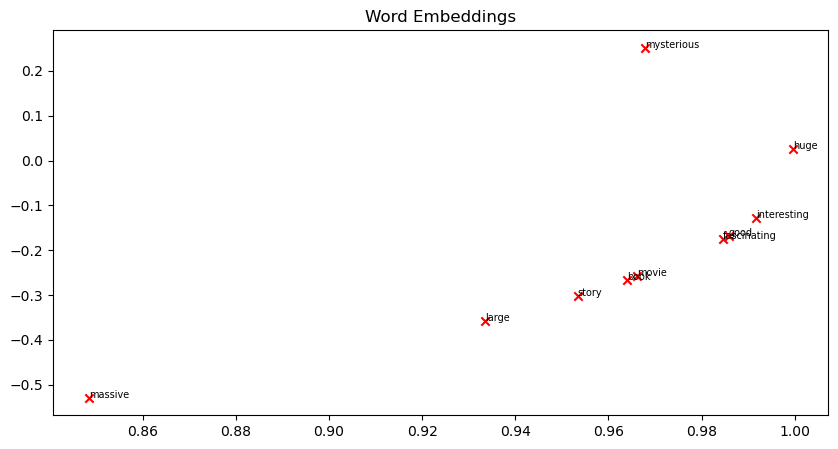

In [ ]:
# -----------------------------
# Run This Cell to Produce Plot.
# ------------------------------

imdbCorpus = readCorpus()
co_occurrenceMatrix, co_occurrence_word2indexDict = gen_co_occurrenceMatrix(imdbCorpus)
co_occurrence_reducedMatrix = k_dim_matrixReduce(co_occurrenceMatrix, k=2)

#Rescale (normalize) the rows to make them each of unit-length.
lengthsMatrix = np.linalg.norm(co_occurrence_reducedMatrix, axis=1)
#Broadcasting: auto convert smaller array(s) to match the dimensions of the larger one.
normalizedMatrix = co_occurrence_reducedMatrix / lengthsMatrix [:, np.newaxis]

words = ['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']

plotEmbeddings(normalizedMatrix, co_occurrence_word2indexDict, words)

#### a. Find at least two groups of words that cluster together in 2-dimensional embedding space. Give an explanation for each cluster you observe.

##### <font color="red">First group:</font>
- <font color="red"> 'good', 'fascinating', and 'interesting' => All three words are adjectives commonly used by viewers. They all have the same positive semantic similarities in describing an object. Hence, explain why most likely these words are clustered together.</font>

##### <font color="red">Second group:</font>
- <font color="red"> 'movie', 'book', and 'story' =>  All three words are nouns, especially dominant nouns since this is a movie review dataset from IMDB. Likewise, they are all semantically similar that present an object viewers saw and reviewed.</font>
- <font color="red"> Interestingly, 'book' and 'movie' seems to be closer than 'story'. This can be analyzed that a movie was produced based on a book. While a story just represents the plot of a book/movie. </font>

##### <font color="red"> Note that different parts of speech can be clustered together, it just happens that words in the same cluster in this case are in the same parts of speech. </font>

##### b. What doesn't cluster together that you might think should have? Describe at least two examples.

- <font color="red"> 'massive' and 'huge' are words that should be clustered together since they have semantic similarities but they are very wide apart in the scatterplot. This could be resulted from review contents, perhaps users do not tend to use these two words together.<\font>
- <font color="red"> 'large' should also be in the same cluster as ['massive' and 'huge'] since it also describes an object's great capacity.<\font>

### Part 2: Prediction-Based Word Vectors

In [ ]:
def load_embeddingModel():
    '''Load GloVe Vectors.
       Return: wv_from_bin: All 400000 embeddings, each length 200.'''

    import gensim.downloader as api
    wordVector_fromBin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wordVector_fromBin.index_to_key)))
    return wordVector_fromBin

In [ ]:
wordVector_fromBin = load_embeddingModel()

Loaded vocab size 400000


In [ ]:
def gen_vectorMatrix(wordVector_fromBin, requiredWords):
    '''Put the GloVe Vectors into a matrix M.
       Param: wordVector_fromBin: KeyedVectors object; the 400000 GloVe vectors loaded from file.
       Return: M: numpy matrix shape (num words, 200) containing the vectors.
               word2ind: dictionary mapping each word to its row number in M.'''

    import random
    import gensim.downloader as api
    words = list(wordVector_fromBin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    print("Putting %i words into word2ind and matrix M..." % len(words))

    word2indexDict = {}
    M = []
    currentIndex = 0
    for word in words:
        try:
            M.append(wordVector_fromBin.get_vector(word))
            word2indexDict[word] = currentIndex
            currentIndex += 1
        except KeyError:
            continue
    for w in requiredWords:
        if w in words:
            continue
        try:
            M.append(wordVector_fromBin.get_vector(w))
            word2indexDict[w] = currentIndex
            currentIndex += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2indexDict

In [ ]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions.
# Note: This should be quick to run.
# -----------------------------------------------------------------

M, word2indexDict = gen_vectorMatrix(wordVector_fromBin, words)
reducedM = k_dim_matrixReduce(M, k=2)

#Rescale (normalize) the rows to make them each of unit-length.
lengthsM = np.linalg.norm(reducedM, axis=1)
#Broadcasting.
normalized_reducedM = reducedM / lengthsM[:, np.newaxis]

Shuffling words ...
Putting 400000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 400000 words...
Done.


#### Question 2.1: GloVe Plot Analysis

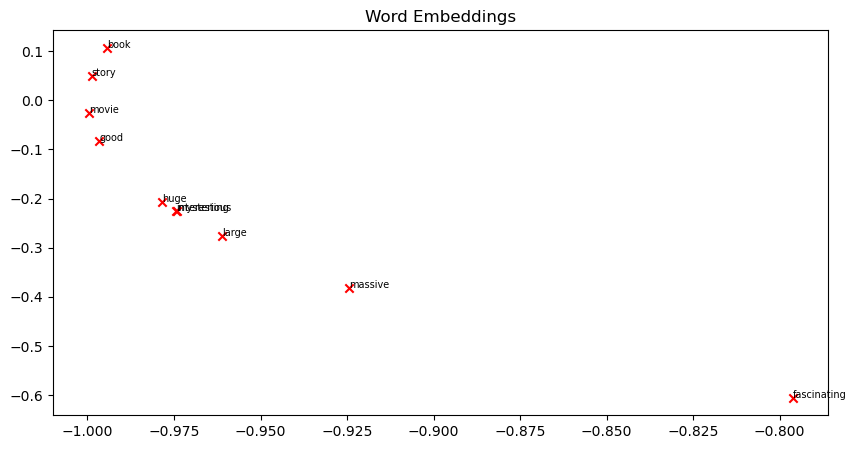

In [ ]:
words = ['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']
plotEmbeddings(normalized_reducedM, word2indexDict, words)

##### a. What is one way the plot is different from the one generated earlier from the co-occurrence matrix? What is one way it's similar?

##### <font color="red">Different:</font>
- <font color="red"> 'good', 'fascinating', and 'interesting' are not close by compared to previous graph. Notably, 'interesting' and 'good' can still be considered somewhat close, but 'fascinating' is far away.</font>

##### <font color="red">Similar:</font>
- <font color="red"> 'movie', 'book', and 'story' are still close by with equal distance from each other hence, can be grouped within a cluster. However, in the previous scatter plot, 'book' and 'movie' were pretty much next to each other.</font>

##### b. Why might the GloVe plot (question_2.1.png) differ from the plot generated earlier from the co-occurrence matrix (question_1.5.png)?

In [ ]:
print(f"Number of unique words in IMDB corpus: {len(co_occurrence_word2indexDict)}")

Number of unique words in IMDB corpus: 5880


- <font color="red"> Since GloVe includes 400,000 words, which is much larger than the 5,880 unique words manually reduced and vectorized through the co-occurrence matrix, the embedding vectors in GloVe capture some what different semantic relationships. This leads to a difference in how word similarities are constructed compared to the co-occurrence matrix. </font>
- <font color="red"> Despite this, both scatterplots show somewhat similar patterns. If the goal is to preserve the interconnected semantic relationships of words within IMDB movie reviews, the co-occurrence matrix is a suitable choice. However, to generalize and understand broader patterns, GloVe is more effective. </font>

#### Question 2.2: Words with Multiple Meanings

##### <font color="red">First word - 'head'- polysemes:</font>

In [ ]:
similarWords1 = wordVector_fromBin.most_similar('head', topn=10)
for i, (similarWord, similarity) in enumerate(similarWords1, 1):
    print(f"{i}. {similarWord}")

1. heads
2. headed
3. chief
4. body
5. assistant
6. director
7. deputy
8. hand
9. left
10. arm


##### <font color="red">Multiple meanings that occur in the top 10:</font>
- <font color="red">Leader/Person in Charge: 'chief', 'assistant', 'director', 'deputy'.</font>
- <font color="red">Physical Body Part: 'body', 'hand', 'arm'.</font>

In [ ]:
similarWords2 = wordVector_fromBin.most_similar('cap', topn=10)
for i, (similarWord, similarity) in enumerate(similarWords2, 1):
    print(f"{i}. {similarWord}")

1. caps
2. salary
3. uniform
4. hat
5. blue
6. shirt
7. matching
8. wearing
9. d'antibes
10. helmet


##### <font color="red">Multiple meanings that occur in the top 10:</font>
- <font color="red">Clothing/Headwear: 'hat', 'helmet', 'shirt', 'wearing'.</font>
- <font color="red">Limit/Maximum: 'salary'.</font>
- <font color="red">Notably, "d'antibes" is name of a city in Southeastern France. This to show that similarity here is determined by context.</font>

##### <font color="red">Reason many of the polysemous or homonymic words didn't work (i.e. the top-10 most similar words only contain one of the meanings of the words):</font>
- <font color="red">Since word embeddings are created based on context similarity, polysemous and homonymous words are often used more frequently in relation to a particular meaning, aka. a dominant definition. Hence, potentially the dominant meaning will be more strongly encoded in the word's vector, and in some cases yield only similar words associated with that commonly used definition.</font>

#### Question 2.3: Synonyms & Antonyms

In [ ]:
distance1 = wordVector_fromBin.distance('love','adore')
print(f"Synonyms: 'love' - 'adore': {distance1:.4f}")
distance2 = wordVector_fromBin.distance('love','hate')
print(f"Antonyms: 'love' - 'hate': {distance2:.4f}")

Synonyms: 'love' - 'adore': 0.6330
Antonyms: 'love' - 'hate': 0.4935


##### <font color="red">A possible explanation for why this counter-intuitive result may have happened:</font>
- <font color="red">This occurs because word embeddings are context-dependent. In practice, antonyms are often used together in sentences or paragraphs for comparison -- for example: 'love' vs. 'hate', whereas synonyms are less likely to co-occur as writers tend to avoid repetition.</font>
- <font color="red">As a result, the embeddings of antonyms can be closer in vector space due to their frequent contextual proximity, leading to a smaller distance between opposites compared to synonyms, which are used less frequently together.</font>

#### Question 2.4: Analogies with Word Vectors

In [ ]:
#Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wordVector_fromBin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005682587623596),
 ('father', 0.6659887433052063),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767976760864),
 ('grandparents', 0.644661009311676),
 ('wife', 0.6445354223251343)]


##### <font color="red">m: 'man' | g: 'grandfather' | w: 'women' | x: answer/output. The expression in which we are maximizing cosine similarity with x:</font>
- <font color="red">Understanding: Word(s) that is to 'woman' what 'grandfather' is to 'man'.</font>
- <font color="red">positive=['woman', 'grandfather'] => adding (w + g) | negative=['man'] => deducting (-m).</font>
- <font color="red">(woman + grandfather) - man => x = (w + g) - m.</font>

#### Question 2.5: Finding Analogies

##### a. For the previous example, it's clear that "grandmother" completes the analogy. But give an intuitive explanation as to why the most_similar function gives us words like "granddaughter", "daughter", or "mother?

- <font color="red">Words like "granddaughter," "daughter," and "mother" represent female family roles, which makes them contextually similar to "grandmother." Simply put, these words tend to co-occur in discussions about family relationships, especially when describing female members of the family. Resulting the query to prioritize female-related terms in the output, closely aligning them with "grandmother" based on their shared semantic and familial context.</font>

##### b. Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

In [ ]:
#Test the solution.
(x, y, a, b) = ('beanie', 'gloves', 'head', 'hand')
pprint.pprint(wordVector_fromBin.most_similar(positive=['head', 'gloves'], negative=['beanie'])[0])
assert wordVector_fromBin.most_similar(positive=[a, y], negative=[x])[0][0] == b

('hand', 0.5627900958061218)


- <font color="red">'beanie':'gloves' :: 'head':'hand'</font>
- <font color="red">For winter clothes, we wear beanie on our head, corresponding to we wear gloves on our hand.</font>

### Extra Credit

#### EC 1: Guided Analysis of Bias in Word Vectors

In [ ]:
#`positive` indicates the list of words to be similar to.
#`negative` indicates the list of words to be most dissimilar from.
pprint.pprint(wordVector_fromBin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
pprint.pprint(wordVector_fromBin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176787376404),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.49005505442619324),
 ('ethic', 0.4897659420967102),
 ('business', 0.4875852167606354),
 ('respected', 0.485920250415802),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572618961334),
 ('life', 0.4760662019252777)]

[('professions', 0.5957457423210144),
 ('practitioner', 0.49884122610092163),
 ('teaching', 0.48292139172554016),
 ('nursing', 0.48211804032325745),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.46937814354896545),
 ('educator', 0.46524327993392944),
 ('physicians', 0.4628995358943939),
 ('professionals', 0.4601394236087799)]


##### (a) Which terms are most similar to "woman" and "profession" and most dissimilar to "man".

- <font color="red">'teaching', 'nursing', 'educator', 'teacher', 'physicians'.</font>

##### (b) Which terms are most similar to "man" and "profession" and most dissimilar to "woman".

- <font color="red">'reputation', 'business', 'respected', 'skill', 'skills'.</font>

##### Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

- <font color="red">This output clearly shows that male-associated words are skewed towards terms reflecting prestige and respect, while female-associated words emphasize roles related to nurturing and caregiving. Many of the female-associated words share similar semantic meanings, which reflects inherent gender bias in the machine learning model.<font>
- <font color="red">Detecting and addressing this bias is crucial, as machine learning algorithms are increasingly influencing social decisions. If left unchecked, these systems can replicate and perpetuate harmful stereotypes from human input data. Since technology plays such a significant role in shaping modern society, it’s essential that we diminish biases like gender inequality in our models to prevent the reinforcement of harmful patterns from human minds in machines. Addressing these issues ensures that AI and machine learning technologies contribute to fairer and more equitable social outcomes.</font>

##### Next, use the most_similar function to find another pair of analogies that demonstrates some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [ ]:
pprint.pprint(wordVector_fromBin.most_similar(positive=['man', 'sports'], negative=['woman']))
print()
pprint.pprint(wordVector_fromBin.most_similar(positive=['woman', 'sports'], negative=['man']))

[('sport', 0.6559334993362427),
 ('baseball', 0.6002753376960754),
 ('sporting', 0.5763919353485107),
 ('soccer', 0.5730218887329102),
 ('football', 0.5716603994369507),
 ('espn', 0.5338577628135681),
 ('entertainment', 0.5199192762374878),
 ('games', 0.5173460841178894),
 ('basketball', 0.5143382549285889),
 ('hockey', 0.4973979592323303)]

[('sport', 0.6103608012199402),
 ('women', 0.5243306756019592),
 ('basketball', 0.5134516358375549),
 ('volleyball', 0.49318623542785645),
 ('soccer', 0.4838080406188965),
 ('athletes', 0.48111116886138916),
 ('athletics', 0.474430650472641),
 ('news', 0.4723058342933655),
 ('athlete', 0.46276983618736267),
 ('gymnastics', 0.4542972147464752)]


- <font color="red">The output demonstrates that men are associated with more profitable and widely known sports, for example: 'football', 'baseball', and 'basketball'. These are sports that receive extensive media coverage and generate significant revenue.</font>
- <font color="red">On the other hand, women are linked to sports that receive less media attention or are considered more niche, such as 'volleyball' and 'gymnastics'. This reflects a gender bias in how sports are perceived and represented in society, with male-dominated sports being prioritized in terms of visibility and profitability.</font>

#### EC 2: Thinking About Bias

#### a. Give one explanation of how bias gets into the word vectors. Briefly describe a real-world example that demonstrates this source of bias. Your real-world example should be focused on word vectors, as opposed to bias in other AI systems (e.g., ChatGPT).

- <font color="red">Since word vectors are trained on large-scale, real-world human-made data, they inevitably reflect societal biases present in that data. This includes historical materials that capture the evolution of societal norms, behaviors, and stereotypes—thus introducing biases into the vectors.</font>
- <font color="red">A real-world example could be racial associations in the context of crime. For instance, black :: white. The output below shows that the white race is associated with white-collar crimes like corruption, while the black race is linked more to violent or gang-related crimes. For instance, white:corruption :: black:gang </font>

- <font color="red">These biases are deeply embedded in the training data due to how our society has evolved and behaved over time. While it may seem inevitable for word vectors to pick up on these patterns, it is critical to recognize and address these biases. Solutions might include techniques such as bias mitigation in word embeddings, creating balanced training datasets, or applying algorithmic fairness methods.</font>

- <font color="red">By doing so, we can ensure that AI systems, especially those used in sensitive areas like job applications or criminal justice systems, do not reinforce existing inequalities or make biased decisions. Recognizing and minimizing such biases is essential for building fairer, more equitable machine learning models.</font>

In [ ]:
pprint.pprint(wordVector_fromBin.most_similar(positive=['white', 'crime'], negative=['black']))
print()
pprint.pprint(wordVector_fromBin.most_similar(positive=['black', 'crime'], negative=['white']))

[('criminal', 0.6426590085029602),
 ('crimes', 0.6286289691925049),
 ('terrorism', 0.5987681150436401),
 ('dealing', 0.5486330986022949),
 ('enforcement', 0.5384438633918762),
 ('corruption', 0.536178708076477),
 ('fbi', 0.5332545638084412),
 ('criminals', 0.5239221453666687),
 ('trafficking', 0.5194993019104004),
 ('murder', 0.5187350511550903)]

[('criminal', 0.5824968814849854),
 ('murder', 0.5666751861572266),
 ('trafficking', 0.5633336305618286),
 ('crimes', 0.5512769222259521),
 ('murders', 0.5351517200469971),
 ('gangs', 0.5348795652389526),
 ('gang', 0.5202505588531494),
 ('homicide', 0.515967607498169),
 ('violent', 0.5078491568565369),
 ('criminals', 0.5074379444122314)]


#### b. What is one method you can use to mitigate bias exhibited by word vectors? Briefly describe a real-world example that demonstrates this method.

##### Citation:
Papakyriakopoulos, O., Hegelich, S., Serrano, J. C. M., & Marco, F. (2020, January). Bias in word embeddings. In Proceedings of the 2020 conference on fairness, accountability, and transparency (pp. 446-457).

##### <font color="red">The studies explores two ways to reduce bias in word vectors.</font>
- <font color="red">The first method - debiasing word embeddings - adjusts word embeddings to make neutral words (like names) less biased by making them unrelated to positive or negative sentiment.</font>
- <font color="red">The second method - adjusting the classifier's decision boundary - so that it doesn't rely on biased word relationships when making predictions.</font>
- <font color="red">Overall, the classifier-level correction proved to be more effective than embedding-level debiasing, as it accounts for more complex relationships learned during training.</font>